<a href="https://colab.research.google.com/github/tzlilLV97/Deep-Learning-Final-Project/blob/main/V1_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project - Deep learning Course



**Project Name** : *Predict League of Legends victory*

Tzlil Lev or 318646510

Alon Feldman  312213135



# Introduction

League of Legends is a highly popular multiplayer online battle arena game, with millions of players worldwide. In this game, two teams of five players compete against each other to destroy the opposing team's nexus, which is located in the base of the opposing team. The game has a vast number of players and it is one of the most played games in the world, thus making it an interesting dataset to work on.

This project aims to predict the winning team in League of Legends matches using a neural network. The dataset provided includes information such as the number of kills, first blood, first baron, game time, and outcome of each match. The goal is to train a model that can accurately predict the winning team using this data (a classification task). The project will also explore the effect of different features and feature engineering techniques on the model's performance. Overall, the project aims to improve gameplay decision-making in the future.

# Dataset

This is a collection of over 50,000 ranked EUW games from the game League of Legends, as well as json files containing a way to convert between champion and summoner spell IDs and their names. For each game, there are fields for:

* Game ID
* Creation Time (in Epoch format)
* Game Duration (in seconds)
* Season ID
* Winner (1 = team1, 2 = team2)
* First Baron, dragon, tower, blood, inhibitor and Rift Herald (1 = team1, 2 =  team2, 0 = none)
* Champions and summoner spells for each team (Stored as Riot's champion and summoner spell IDs)
* The number of tower, inhibitor, Baron, dragon and Rift Herald kills each team has
* The 5 bans of each team (Again, champion IDs are used)


This dataset was collected using the Riot Games API, which makes it easy to lookup and collect information on a users ranked history and collect their games. However finding a list of usernames is the hard part, in this case I am using a list of usernames scraped from 3rd party LoL sites.

A link to the [dataset](https://www.kaggle.com/datasets/datasnaek/league-of-legends) 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import collections
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import xgboost as xgb
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc,precision_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score,f1_score

In [36]:
from google.colab import drive
drive.mount('/content/gdrive')
PATH_TO_DATA_ALON = '/content/gdrive/My Drive/Colab Notebooks/DNNPROJECT/games.csv' 
PATH_TO_DATA_TZLIL = '/content/gdrive/MyDrive/Colab Notebooks/data/games.csv'
PATH_TO_DATA = PATH_TO_DATA_TZLIL
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Set the Randomness Seed : 
np.random.seed(121)



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Data analysis

First, we will load the dataset and eliminate unimportant columns, including gameID, season, and creation time. These fields will be removed as they are not relevant to the analysis. The game ID serves as an index and the creation time does not hold significance as League of Legends is a globally played game, and all the matches were conducted during the same season.

In [3]:
df = pd.read_csv(PATH_TO_DATA)
df.drop(df.columns[[0,1,3]], axis=1, inplace=True)

### Missing values check


In [4]:
# Check for nan values
#msno.bar(df,figsize=(8,12),te)
#msno.matrix(df)
#Print missing data sorted by percentage of total values
pd.set_option('display.max_rows', None)
missing_data = pd.DataFrame({'Total Missing': df.isnull().sum(), 'Percentage of Total Values': df.isnull().sum()/len(df)})
print(missing_data.sort_values('Percentage of Total Values', ascending=False))


                    Total Missing  Percentage of Total Values
gameDuration                    0                         0.0
t2_champ4_sum1                  0                         0.0
t1_ban4                         0                         0.0
t1_ban5                         0                         0.0
t2_champ1id                     0                         0.0
t2_champ1_sum1                  0                         0.0
t2_champ1_sum2                  0                         0.0
t2_champ2id                     0                         0.0
t2_champ2_sum1                  0                         0.0
t2_champ2_sum2                  0                         0.0
t2_champ3id                     0                         0.0
t2_champ3_sum1                  0                         0.0
t2_champ3_sum2                  0                         0.0
t2_champ4id                     0                         0.0
t2_champ4_sum2                  0                         0.0
winner  

**Conclusion**

 We are lucky students, all of our data is complete. 


### Correlation Analysis of Features

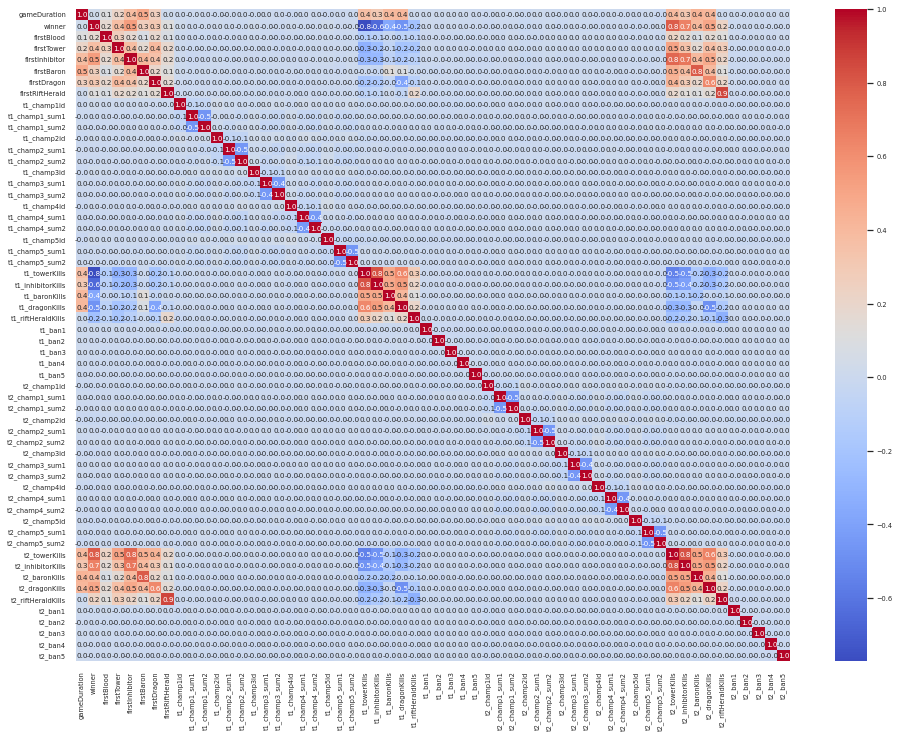

In [ ]:
sns.set(font_scale=0.6)
plt.figure(figsize=(16, 12))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True,fmt='.1f')

From the correlation heat map, it is clear that there are several feature pairs that have little to no correlation with each other, as indicated by the gray areas. We will now focus our attention on the feature pairs that have a strong correlation, as identified by the red and blue areas on the map. These correlated features will be the primary focus of our further analysis and interpretation.

Index(['gameDuration', 'winner', 'firstBlood', 'firstTower', 'firstInhibitor',
       'firstBaron', 'firstDragon', 'firstRiftHerald', 't1_champ1id',
       't1_champ2id', 't1_champ3id', 't1_champ4id', 't1_champ5id',
       't1_towerKills', 't1_inhibitorKills', 't1_baronKills', 't1_dragonKills',
       't1_riftHeraldKills', 't2_champ1id', 't2_champ2id', 't2_champ3id',
       't2_champ4id', 't2_champ5id', 't2_towerKills', 't2_inhibitorKills',
       't2_baronKills', 't2_dragonKills', 't2_riftHeraldKills'],
      dtype='object')


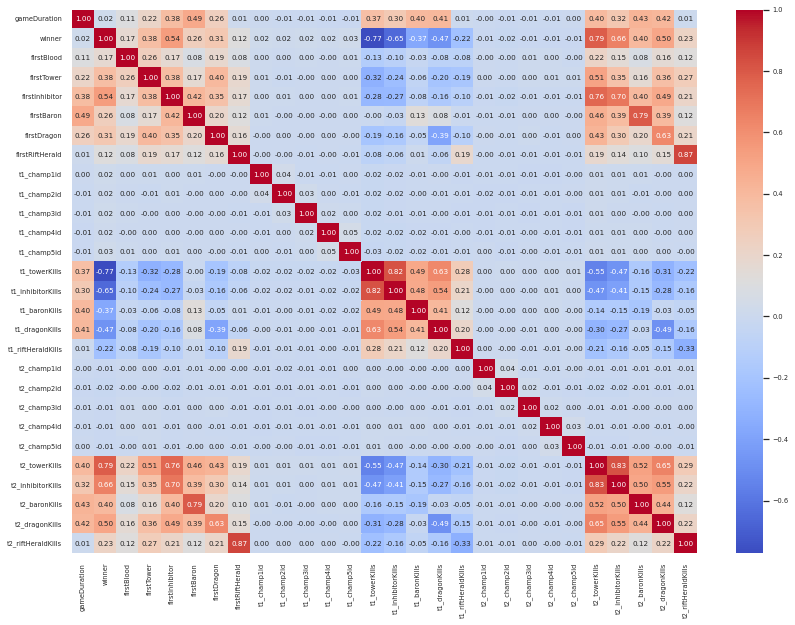

In [ ]:
df_partA = pd.read_csv(PATH_TO_DATA).iloc[:, [2, 4, 5, 6, 7, 8, 9, 10, 11, 14, 17, 20, 23, 26, 27, 28, 29, 30, 36, 39, 42, 45, 48,  51, 52, 53, 54, 55]]
print(df_partA.columns)
plt.figure(figsize=(14, 10))
sns.heatmap(df_partA.corr(), cmap='coolwarm', annot=True,fmt='.2f')

After droping some features we can see a more correlated heat map, 
We'll keep removing the uncorrelated features.

Index(['gameDuration', 'winner', 'firstBlood', 'firstTower', 'firstInhibitor',
       'firstBaron', 'firstDragon', 'firstRiftHerald', 't1_towerKills',
       't1_inhibitorKills', 't1_baronKills', 't1_dragonKills',
       't1_riftHeraldKills', 't2_towerKills', 't2_inhibitorKills',
       't2_baronKills', 't2_dragonKills', 't2_riftHeraldKills'],
      dtype='object')


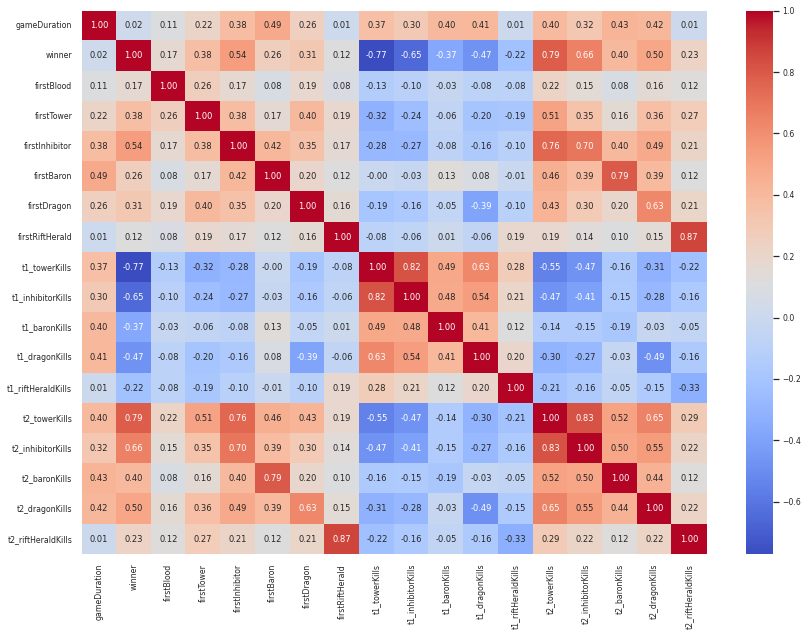

In [ ]:
df_partB = pd.read_csv(PATH_TO_DATA).iloc[:, [2, 4, 5, 6, 7, 8, 9, 10, 26, 27, 28, 29, 30, 51, 52, 53, 54, 55]]
print(df_partB.columns)
sns.set(font_scale=0.7)
plt.figure(figsize=(14, 10))
sns.heatmap(df_partB.corr(), cmap='coolwarm', annot=True,fmt='.2f')

We will now proceed with analyzing and interpreting the features that do not exhibit a strong correlation, as indicated by the gray areas in the correlation heat map.

Index(['gameDuration', 'winner', 't1_champ1id', 't1_champ2id', 't1_champ3id',
       't1_champ4id', 't1_champ5id', 't2_champ1id', 't2_champ2id',
       't2_champ3id', 't2_champ4id', 't2_champ5id'],
      dtype='object')


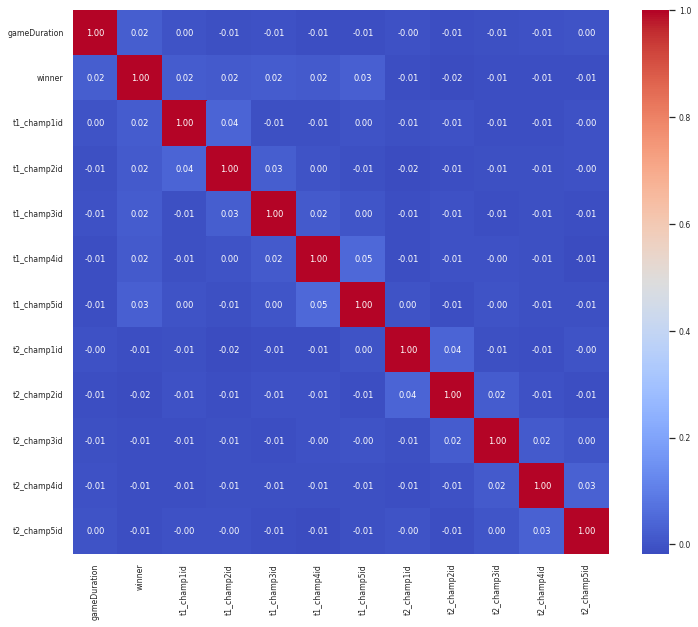

In [ ]:
df_partC = pd.read_csv(PATH_TO_DATA).iloc[:, [2, 4, 11, 14, 17, 20, 23,  36, 39, 42, 45, 48,]]
print(df_partC.columns)
sns.set(font_scale=0.7)
plt.figure(figsize=(12, 10))
sns.heatmap(df_partC.corr(), cmap='coolwarm', annot=True,fmt='.2f')

In this analysis, we aim to investigate the potential correlation between the champions selected by each team and their respective spell choices. \\
Based on our gaming experience, we hypothesize that there is a connection between the two factors and intend to validate this hypothesis through data analysis. \\
The disparities in the graph are a result of the non-consecutive numbering of the champion and spell IDs in the dataset.

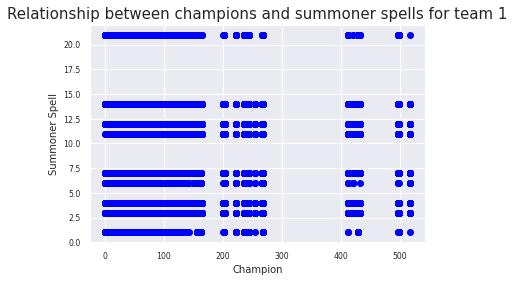

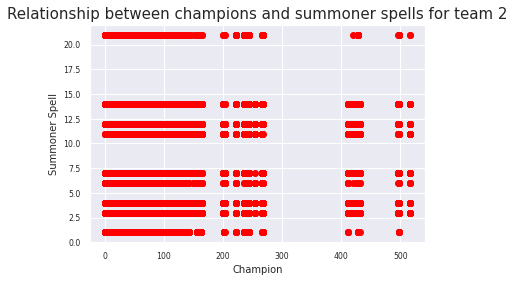

In [ ]:
plt.scatter(df['t1_champ1id'], df['t1_champ1_sum1'], color = 'blue')
plt.scatter(df['t1_champ2id'], df['t1_champ2_sum1'], color = 'blue')
plt.scatter(df['t1_champ3id'], df['t1_champ3_sum1'], color = 'blue')
plt.scatter(df['t1_champ4id'], df['t1_champ4_sum1'], color = 'blue')
plt.scatter(df['t1_champ5id'], df['t1_champ5_sum1'], color = 'blue')
plt.scatter(df['t1_champ1id'], df['t1_champ1_sum2'], color = 'blue')
plt.scatter(df['t1_champ2id'], df['t1_champ2_sum2'], color = 'blue')
plt.scatter(df['t1_champ3id'], df['t1_champ3_sum2'], color = 'blue')
plt.scatter(df['t1_champ4id'], df['t1_champ4_sum2'], color = 'blue')
plt.scatter(df['t1_champ5id'], df['t1_champ5_sum2'], color = 'blue')
plt.title('Relationship between champions and summoner spells for team 1',fontsize=15)
plt.xlabel('Champion',fontsize=10)
plt.ylabel('Summoner Spell',fontsize=10)
plt.show()

plt.scatter(df['t2_champ1id'], df['t2_champ1_sum1'], color = 'red')
plt.scatter(df['t2_champ2id'], df['t2_champ2_sum1'], color = 'red')
plt.scatter(df['t2_champ3id'], df['t2_champ3_sum1'], color = 'red')
plt.scatter(df['t2_champ4id'], df['t2_champ4_sum1'], color = 'red')
plt.scatter(df['t2_champ5id'], df['t2_champ5_sum1'], color = 'red')
plt.scatter(df['t2_champ1id'], df['t2_champ1_sum2'], color = 'red')
plt.scatter(df['t2_champ2id'], df['t2_champ2_sum2'], color = 'red')
plt.scatter(df['t2_champ3id'], df['t2_champ3_sum2'], color = 'red')
plt.scatter(df['t2_champ4id'], df['t2_champ4_sum2'], color = 'red')
plt.scatter(df['t2_champ5id'], df['t2_champ5_sum2'], color = 'red')
plt.title('Relationship between champions and summoner spells for team 2',fontsize=15)
plt.xlabel('Champion',fontsize=10)
plt.ylabel('Summoner Spell',fontsize=10)
plt.show()

And now only with the first kills:

Index(['gameDuration', 'winner', 'firstBlood', 'firstTower', 'firstInhibitor',
       'firstBaron', 'firstDragon', 'firstRiftHerald'],
      dtype='object')


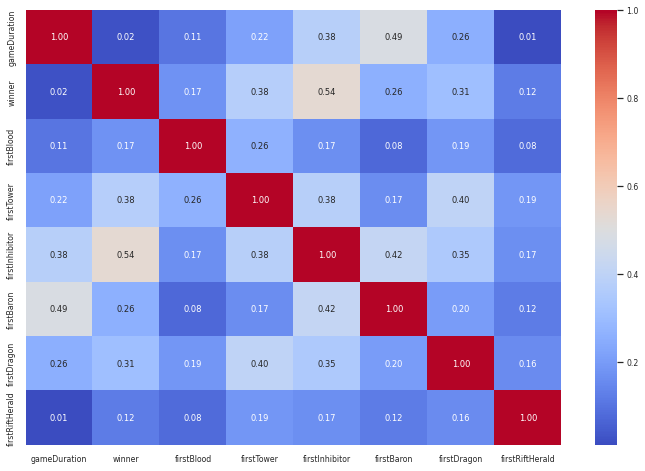

In [ ]:
df_partD = pd.read_csv(PATH_TO_DATA).iloc[:, [2, 4, 5, 6, 7, 8, 9, 10]]
print(df_partD.columns)
sns.set(font_scale=0.7)
plt.figure(figsize=(12, 8))
sns.heatmap(df_partD.corr(), cmap='coolwarm', annot=True,fmt='.2f')

Finally, with total kills:

Index(['gameDuration', 'winner', 't1_towerKills', 't1_inhibitorKills',
       't1_baronKills', 't1_dragonKills', 't1_riftHeraldKills',
       't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills',
       't2_riftHeraldKills'],
      dtype='object')


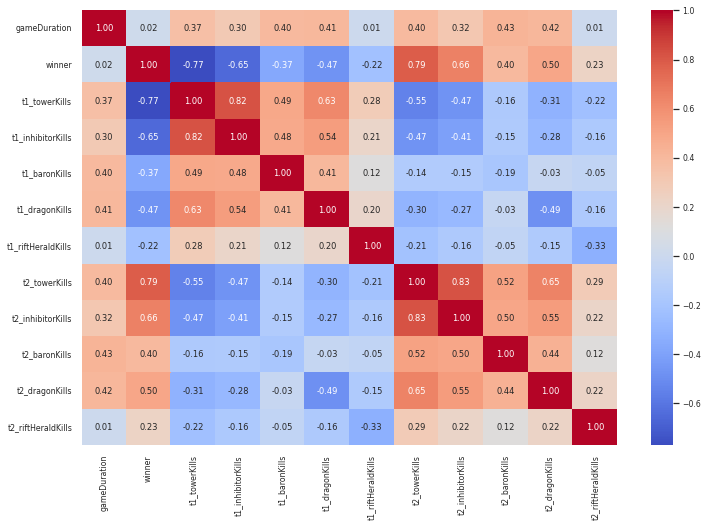

In [ ]:
df_partE = pd.read_csv(PATH_TO_DATA).iloc[:, [2, 4, 26, 27, 28, 29, 30, 51, 52, 53, 54, 55]]
print(df_partE.columns)
sns.set(font_scale=0.7)
plt.figure(figsize=(12, 8))
sns.heatmap(df_partE.corr(), cmap='coolwarm', annot=True,fmt='.2f')

**Conclusion**

Our analysis of the data revealed that there is a lack of correlation between the selected champions and the outcome of the game. Furthermore, the distribution of chosen spells appeared to be uniform, leading us to conclude that these factors do not have a significant impact on the likelihood of victory. \\
As anticipated, the number of kills and, in certain instances, the team that achieved the first kill of an important objective (such as the inhibitor, with a correlation coefficient of 0.54 to the winner) were found to have the strongest correlation with the outcome of the game. \\
Additionally, a logical correlation was identified between game duration and number of kills, as an increased duration of gameplay would logically allow for a greater potential for kills to occur.





### Evaluation of Data Imbalance




First, we will investigate the balance of victories between team1 and team2 in the dataset. \\
By ensuring that the distribution of wins is equal between the teams, we can infer that the training, \\
validation, and testing data will also be balanced under the assumption of a uniform distribution.

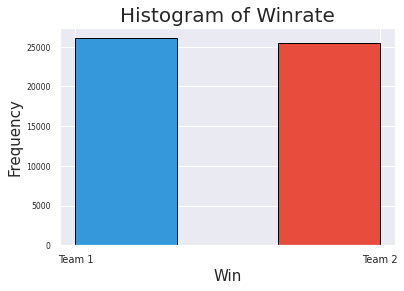

In [ ]:
plotColors = ['#3498DB','#E74C3C','#BDC3C7']
fig, ax = plt.subplots()

N, bins, patches = ax.hist(df['winner'],edgecolor='black', histtype='bar',bins=3)
patches[0].set_facecolor(plotColors[0])
patches[2].set_facecolor(plotColors[1])

ax.set_title('Histogram of Winrate',fontsize=20)
ax.set_xlabel('Win',fontsize=15)
ax.set_ylabel('Frequency',fontsize=15)
ax.set_xticks([1,2])
ax.set_xticklabels(['Team 1','Team 2'],fontsize = 10)
plt.show() 

We will conduct a similar analysis for the "First" actions, to ensure that the distribution of these features is balanced across the dataset.

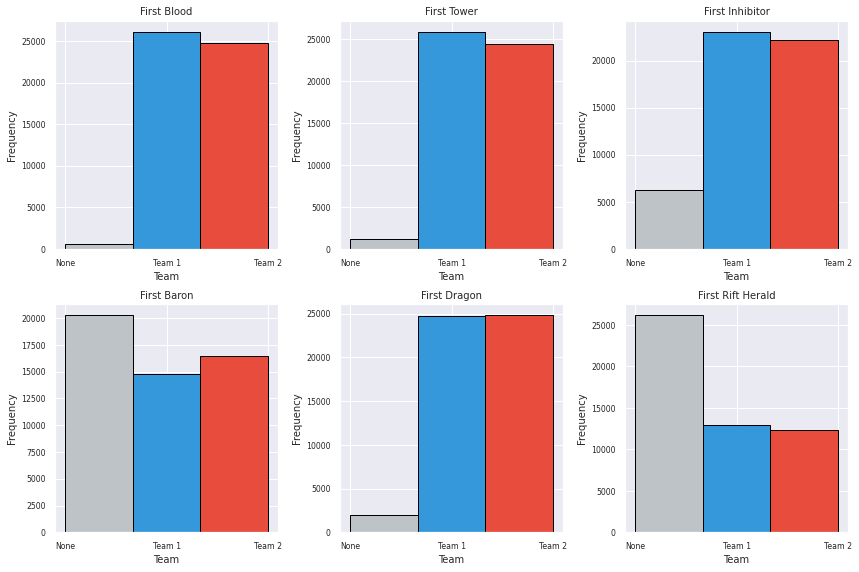

In [ ]:
fig, axs = plt.subplots(2, 3)
ax0, ax1, ax2, ax3, ax4, ax5 = axs.flatten()
N, bins, patches = ax0.hist(df['firstBlood'],ec='black', histtype='bar',bins=3)
patches[0].set_facecolor(plotColors[2])
patches[1].set_facecolor(plotColors[0])
patches[2].set_facecolor(plotColors[1])
ax0.set_title('First Blood',fontsize=10)
ax0.set_xlabel('Team',fontsize=10)
ax0.set_ylabel('Frequency',fontsize=10)
N, bins, patches = ax1.hist(df['firstTower'],ec='black', histtype='bar',bins=3)
patches[0].set_facecolor(plotColors[2])
patches[1].set_facecolor(plotColors[0])
patches[2].set_facecolor(plotColors[1])
ax1.set_title('First Tower',fontsize=10)
ax1.set_xlabel('Team',fontsize=10)
ax1.set_ylabel('Frequency',fontsize=10)
N, bins, patches = ax2.hist(df['firstInhibitor'],ec='black', histtype='bar',bins=3)
patches[0].set_facecolor(plotColors[2])
patches[1].set_facecolor(plotColors[0])
patches[2].set_facecolor(plotColors[1])
ax2.set_title('First Inhibitor',fontsize=10)
ax2.set_xlabel('Team',fontsize=10)
ax2.set_ylabel('Frequency',fontsize=10)
N, bins, patches = ax3.hist(df['firstBaron'],ec='black', histtype='bar',bins=3)
patches[0].set_facecolor(plotColors[2])
patches[1].set_facecolor(plotColors[0])
patches[2].set_facecolor(plotColors[1])
ax3.set_title('First Baron',fontsize=10)
ax3.set_xlabel('Team',fontsize=10)
ax3.set_ylabel('Frequency',fontsize=10)
N, bins, patches = ax4.hist(df['firstDragon'],ec='black', histtype='bar',bins=3)
patches[0].set_facecolor(plotColors[2])
patches[1].set_facecolor(plotColors[0])
patches[2].set_facecolor(plotColors[1])
ax4.set_title('First Dragon',fontsize=10)
ax4.set_xlabel('Team',fontsize=10)
ax4.set_ylabel('Frequency',fontsize=10)
N, bins, patches = ax5.hist(df['firstRiftHerald'],ec='black', histtype='bar',bins=3)
patches[0].set_facecolor(plotColors[2])
patches[1].set_facecolor(plotColors[0])
patches[2].set_facecolor(plotColors[1])
ax5.set_title('First Rift Herald',fontsize=10)
ax5.set_xlabel('Team',fontsize=10)
ax5.set_ylabel('Frequency',fontsize=10)
plt.setp(axs, xticks=[0,1,2], xticklabels=['None','Team 1','Team 2'])
fig.set_figheight(8)
fig.set_figwidth(12)
fig.tight_layout()


For the number of kills, we will conduct a box plot analysis. 


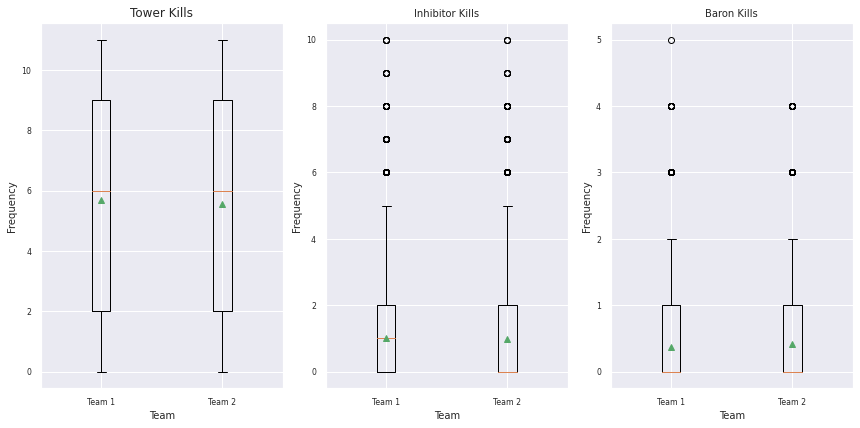

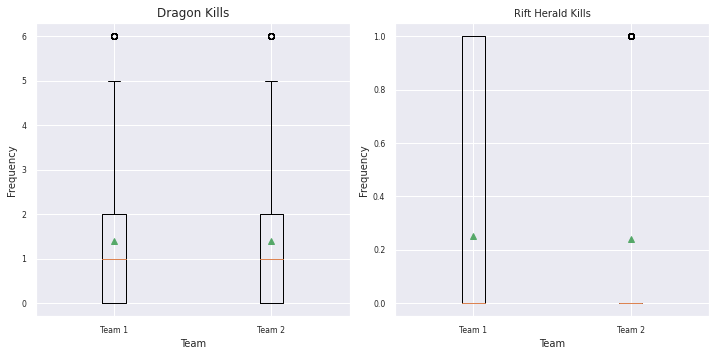

********************
Rift Herald Kills: 
 Team 1 =  12948  Team 2 =  12363
********************


In [ ]:
fig, axs = plt.subplots(1, 3)
ax0, ax1, ax2 = axs.flatten()
ax0.boxplot([df['t1_towerKills'],df['t2_towerKills']], labels = ['Team 1','Team 2'],
            patch_artist=False,showmeans=True)
ax0.set_title('Tower Kills',fontsize=12)
ax0.set_xlabel('Team',fontsize=10)
ax0.set_ylabel('Frequency',fontsize=10)
ax1.boxplot([df['t1_inhibitorKills'],df['t2_inhibitorKills']], labels = ['Team 1','Team 2'],
            patch_artist=False,showmeans=True)
ax1.set_title('Inhibitor Kills',fontsize=10)
ax1.set_xlabel('Team',fontsize=10)
ax1.set_ylabel('Frequency',fontsize=10)
ax2.boxplot([df['t1_baronKills'],df['t2_baronKills']], labels = ['Team 1','Team 2'],
            patch_artist=False,showmeans=True)
ax2.set_title('Baron Kills',fontsize=10)
ax2.set_xlabel('Team',fontsize=10)
ax2.set_ylabel('Frequency',fontsize=10)
fig.set_figheight(6)
fig.set_figwidth(12)
fig.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2)
ax3, ax4 = axs.flatten()
ax3.boxplot([df['t1_dragonKills'],df['t2_dragonKills']], labels = ['Team 1','Team 2'],
            patch_artist=False,showmeans=True)
ax3.set_title('Dragon Kills',fontsize=12)
ax3.set_xlabel('Team',fontsize=10)
ax3.set_ylabel('Frequency',fontsize=10)
ax4.boxplot([df['t1_riftHeraldKills'],df['t2_riftHeraldKills']], labels = ['Team 1','Team 2'],
            patch_artist=False,showmeans=True)
ax4.set_title('Rift Herald Kills',fontsize=10)
ax4.set_xlabel('Team',fontsize=10)
ax4.set_ylabel('Frequency',fontsize=10)
fig.set_figheight(5)
fig.set_figwidth(10)
fig.tight_layout()
plt.show()
print("*"*20)
print('\033[1m'+"Rift Herald Kills: "+'\033[0m'+"\n Team 1 = ",df['t1_riftHeraldKills'].sum()," Team 2 = ",df['t2_riftHeraldKills'].sum())
print("*"*20)

Game duration boxplot

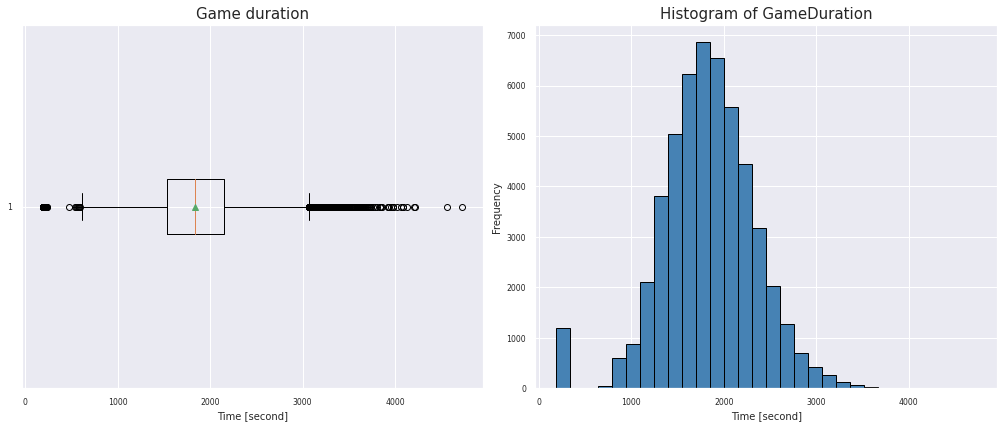

In [ ]:
fig, axs = plt.subplots(1, 2)

axs[0].boxplot(df['gameDuration'],showmeans=True, vert=False)
axs[0].set_title("Game duration", fontsize=15)
axs[0].set_xlabel('Time [second]', fontsize=10)
axs[1].set_title('Histogram of GameDuration',fontsize=15)
axs[1].set_xlabel('Time [second]',fontsize=10)
axs[1].set_ylabel('Frequency',fontsize=10)
axs[1].hist(df['gameDuration'],edgecolor='black',color='steelblue', histtype='bar',bins=30)
fig.set_figheight(6)
fig.set_figwidth(14)
fig.tight_layout()
plt.show()

**Conclusion**

The data appears to be well-balanced, with a similar number of wins for each team and similar values for other features. \\
The "first kill" feature has some entries with no value (0 in the dataset, None in the graph), indicating that no team achieved a kill of that type. \\
number of kills is also well-balanced, with the median and mean being the same for each team. There is a minor outlier that can be addressed through normalization. The boxplot for "Rift Herald Kills" does not show data for Team 2, but the mean and median are the same and the total number of kills is similar for both teams. (we print it below the plot) \\
the game duration feature has some significante outliers (the left bin) that appear to be caused by teams surrendering or quitting the game early. These games have short durations and very few kills (zero or one) and should be removed from the data set.

### Conclustion

*   The data is correct- no missing values, the feauters are balanced, minor outlier that a normalization will fix. 
*   Features selections- from the correlation analysis we decide to drop the champions ID and their spells as it look like no relevante
*   The "game duration" feature- we will drop the samples under 240 sec. After dropping those samples, we notice a significant improvement on the basic implementation we did, as also in the benchmark models (for example, we saw improvement in the XGBoost test accuracy from 97.3% to 98.35%)
In addition, due to the game duration high numeric values we'll try to use log on it to "normalize" it.







## Data preparation

In [10]:
def data_preparation(df_first):
    """
    In this function we'll implement all the conclusion recieved from the data 
    analaysis stage, drop all the unneccersary columns, remove games with
    short game duration and normalize the winner team label so it will be 
    a binary value (team 2 will be 1, and team 1 will be 0), and shuffle the data.
    Finally, we'll seperate between the data and the label spaces, 
    and we'll convert the label space into a one hot vector with 2 coordinates.
    """

    #Drop the Short Games and unneccesary features
    df_first = df_first.drop(df_first[df_first.gameDuration<240].index, axis=0)
    df = df_first.iloc[:, [2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 20, 23, 26, 27, 28, 29, 30, 36, 39, 42, 45, 48,  51, 52, 53, 54, 55]]

    #Optional - Implement log on the game duration
    #df['gameDuration'] = df['gameDuration'].apply(lambda x: np.log(x))


    # Making the label vector binary
    labels = df_first.iloc[:, 4].to_numpy() - 1
    labels = [np.eye(2)[label] for label in labels]
    df = df.to_numpy()
    indices = np.arange(len(df))
    #Shuffle
    np.random.shuffle(indices)
    df = df[indices]
    labels = np.array(labels)[indices]
    return df, labels

def get_train_val_test(data,labels):
  """
  Seperate the data as the following method:
  Train data set will contain 80% of the data
  Validation and Test will each contain 10% of the data
  """
  n=len(data)
  len_train = int(0.8 * n)
  len_test = (n-int(len_train))//2
  len_val = len_test
  train, val, test = (data[:len_train],labels[:len_train]), \
      (data[len_train:len_train+len_test],labels[len_train:len_train+len_test]),\
      (data[len_train+len_test:],labels[len_train+len_test:])
  return train, val, test


df = pd.read_csv(PATH_TO_DATA)
print(df.shape)
data, labels = data_preparation(df)
print(data.shape)
train, valid, test = get_train_val_test(data,labels)


(51490, 61)
(50295, 27)


# Limitations

In our opinion, the following are the project's challenges:


1. Success in defeating the XGBoost—the most terrifying benchmark, which we must defeat!
2. Eventually, this task felt a little too simple and easy for us after the end of Nir's course ("only" classification for 2 classes with tabular dataset that is very balanced and without noise, and so on) so we tried to do a good job in the data analysis.
3. As shown in the data analysis section, we noticed that some samples are very differente- the ones with too short game duration, we concluded that those games are just games that start, and one of the team decided to surrender or quit without logical reason (at the beginning of the LOL game players can give an early surrender as a result of AFK- player that "away from keyboard"), so we decided to call those samples "illegal" and ignore them- because there is no way to predict the winner based on this, there are no kills (most of the time), and it's like a coin toss (50%-50%).





# Network

**Neural Network Implementation** 


We developed a modular class for standart Fully Connected Neural Network that allows for customizable parameters such as the number of neurons in the hidden layers,

 the activation function, dropout, and the type of normalization to be used. The user can specify the number of layers in the network as well.

 The input to this class is the following:

* 'num_hidden': Number of neurons in each layer in the hidden layers, default value is 30

* 'activation': The activation function for the network, options are ReLU, Sigmoid and Tanh, default value is 'ReLU'

* 'dropout': Whether or not to implement dropout on the network, default value is 0. (so no dropout by default)

* 'dropout_value': Percentage of dropout to be applied, default value is 0.2

* 'norm': Type of normalization to be used, options are 'LayerNorm' or None, default value is 'None'

* 'number_of_layers': Number of layers in the network, default value is 2

* 'bypass'- Whether or not to add bypass edges between layers in the network,  options are 'False' or 'True', defaulte- 'False'. If 'True' then add bypass between second layer to the one before the last (only if num_of_layer>3)


The class also includes a 'weight_init' function to randomly initialize the weights and biases of the network and a 'forward' function that defines the forward pass of the network. The forward function applies linear transformations to the input, followed by the specified activation function, dropout and normalization, in each layer of the network. The final output is returned by the forward function.

In [5]:
class FirstBasicNN(nn.Module):
    def __init__(self, num_hidden=30,activation='ReLU',dropout=0,dropout_value=0.2,norm='None',number_of_layers=2,bypass=False):
        super(FirstBasicNN, self).__init__()
        self.input_size = 27  # input_size
        self.hidden_size = num_hidden 
        self.number_of_layers = number_of_layers  
        self.bypass = bypass
        if activation == "ReLU":
          self.activation = torch.nn.ReLU()
        elif activation == "Sigmoid":
            self.activation = torch.nn.Sigmoid()
        elif activation == "Tanh":
            self.activation = torch.nn.Tanh()
        else:
            self.activation = torch.nn.ReLU()
        self.dropout_value = dropout_value
        if dropout == 'Dropout':
          self.droper = torch.nn.Dropout(self.dropout_value)
        else: #Apply a 0 dropout on the data (an empty layer)
            self.droper = nn.Dropout(0)
        if norm=="LayerNorm":
            self.norm = nn.LayerNorm(self.hidden_size)
        else:
            self.norm = nn.Dropout(0) #do nothing
        for i in range(0,self.number_of_layers): #loop to create number of layers
            if i == 0: #input layer
                setattr(self, 'linear'+str(i), nn.Linear(self.input_size, self.hidden_size))
            elif i == self.number_of_layers-1: #ouput layer
                setattr(self, 'linear'+str(i), nn.Linear(self.hidden_size, 2))
            else: #hidden layer
                setattr(self, 'linear'+str(i), nn.Linear(self.hidden_size, self.hidden_size))
            
    def weight_init(self, mean, std):
      for m in self._modules:
          if isinstance(m, nn.Linear):
              m.weight.data.normal_(mean, std)
              m.bias.data.zero_()

    def forward(self, inp):
        if self.bypass:
            for i in range(0, self.number_of_layers):
                if i == 0:
                    inp = getattr(self, 'linear' + str(i))(inp)
                    inp = self.activation(inp)
                    inp = self.droper(inp)
                    inp = self.norm(inp)
                elif i == self.number_of_layers - 1:
                    inp = getattr(self, 'linear' + str(i))(inp)
                else:
                    if self.number_of_layers > 3 and i == 1:
                        bypass = inp
                    inp = getattr(self, 'linear' + str(i))(inp)
                    inp = self.activation(inp)
                    inp = self.droper(inp)
                    inp = self.norm(inp)
                    if self.number_of_layers > 3 and i == self.number_of_layers - 2:
                        inp = bypass + inp
        else:
            for i in range(0, self.number_of_layers):
                if i == 0:
                    inp = getattr(self, 'linear' + str(i))(inp)
                    inp = self.activation(inp)
                    inp = self.droper(inp)
                    inp = self.norm(inp)
                elif i == self.number_of_layers - 1:
                    inp = getattr(self, 'linear' + str(i))(inp)
                else:
                    inp = getattr(self, 'linear' + str(i))(inp)
                    inp = self.activation(inp)
                    inp = self.droper(inp)
                    inp = self.norm(inp)
        return inp


Graph Plotting

In [6]:
def plot_learning_curve(model_data):
  """
  Plot the learning curve in a more professional way.
  """
  iters, losses, iters_sub, train_accs, val_accs = model_data
  fig, axs = plt.subplots(1, 2, figsize=(15, 5))
  axs[0].set_title("Learning Curve: Loss per Epoch")
  axs[0].plot(iters, losses, label="Train")
  axs[0].set_xlabel("Epochs")
  axs[0].set_ylabel("Loss")
  axs[0].legend(loc='best')

  axs[1].set_title("Learning Curve: Accuracy per Iteration")
  axs[1].plot(iters_sub, train_accs, label="Train")
  axs[1].plot(iters_sub, val_accs, label="Validation")
  axs[1].set_xlabel("Epochs")
  axs[1].set_ylabel("Accuracy")
  axs[1].legend(loc='best')

  plt.show()

Accuracy Calculation and function to "Get Batch"

In [7]:
def get_batch(data,labels, start, end):
    """
    get the next batch from the data set, if we in the last batch
    then take what left.
    """    
    try:
      x = data[start:end]
      s = labels[start:end]
      return x, s
    except:
      x = data[start:]
      s = labels[start:]
      return x,s


def estimate_accuracy_torch(model, data, labels, batch_size=5000, max_N=100000):
    """
    Estimate the accuracy of the model on the data. To reduce
    computation time, use at most `max_N` elements of `data` to
    produce the estimate.
    """

    correct = 0
    N = 0
    for i in range(0, len(data), batch_size):
        # get a batch of data
        xt, st = get_batch(data, labels, i, i + batch_size)
        if torch.cuda.is_available():
          xt = torch.Tensor(xt).cuda()
          st = torch.Tensor(st).cuda().float()
        else:
          xt = torch.Tensor(xt).to(device)
          st = torch.Tensor(st).to(device).float()
        y = model(xt)
        _, pred = torch.max(y, 1)
        _, true = torch.max(st, 1)
        correct += (pred == true).sum().item()
        N += len(st)

        if N > max_N:
            break
    return correct / N

**Trainning**

The function "train model" is used to train our model, and it is very similar to the train function we have been using in the course, except that this function is a little more flexible and can take as arguments the cost function, optimizer, and so on. 

The cost function used in this function are :

* Mean Squared Error (MSE)
* Cross Entropy Loss (CE)
* Binary Cross Entropy with Logits Loss (BCEWithLogitsLoss)


The optimizer used in this function are :

* Stochastic Gradient Descent (SGD)
* RMSprop (RMS)
* ADAM
* Adamax

Next we will use Grid Search to find the best hyperParameters.

In [27]:
def train_model(model, train_data,validation_data,test_data,
                                hypers=[],flag=False):
  #Hypers = [cost, Optimizer, Learning Rate, Weight Decay,epochs,batch_size]

  if len(hypers) != 6:
    print("must pass 6 hyperParameters: [cost, Optimizer, Learning Rate, Weight Decay,epochs,batch_size]")
    return
  epochs = hypers[4]
  batch_size = hypers[5]

  # Cost Functions
  if hypers[0] == 'MSE':
    criterion = nn.MSELoss()
  elif hypers[0] == 'CE':
    criterion = nn.CrossEntropyLoss()
  elif hypers[0] == 'BCEWithLogitsLoss':
    criterion = nn.BCEWithLogitsLoss()
  else:
    criterion = nn.CrossEntropyLoss(reduction='mean')

  ## OPTIMIZERS
  if hypers[1] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=hypers[2], momentum=0.9)
  elif hypers[1] == 'RMS':
      optimizer = optim.RMSprop(model.parameters(), lr=hypers[2], alpha=0.99, eps=1e-08, weight_decay=hypers[3], momentum=0, centered=False)
  elif hypers[1] == 'ADAM':
      optimizer = optim.Adam(model.parameters(), lr=hypers[2], weight_decay=hypers[3])
  else:
      optimizer = optim.Adamax(model.parameters(), lr=hypers[2], betas=(0.9, 0.999), eps=1e-08, weight_decay=hypers[3])

  iters, losses = [], []
  iters_sub, train_accs, val_accs = [], [], []
  optimizer.zero_grad()
  n = 0  # the number of iterations
  train=train_data[0]
  label=train_data[1]
  #start train for number of epoch
  for n in range(0,epochs):
      #in each epoch, start with shuffle the train data and then 
      # iterate over the batches
      train_data
      indices = np.arange(len(train_data[0]))
      np.random.shuffle(indices)
      train = train[indices]
      label = np.array(label)[indices]
      for i in range(0, train_data[0].shape[0], batch_size):
          #Clean the grad
          optimizer.zero_grad()
          # get the input and targets of a minibatch
          xt, st = get_batch(train,label, i, i + batch_size)
          if torch.cuda.is_available():
            xt = torch.Tensor(xt).cuda()
            st = torch.Tensor(st).cuda().float()
          else:
            xt = torch.Tensor(xt).to(device)
            st = torch.Tensor(st).to(device).float()
          zs = model(xt)
          loss = criterion(zs, st)  # compute the total loss
          loss.backward()  # compute updates for each parameter
          optimizer.step()  # make the updates for each parameter
      #after the epoch evaluate on the validation
      losses.append(float(loss) / batch_size)  # compute average loss
      iters.append(n)
      iters_sub.append(n)
      train_cost = float(loss.cpu().detach().numpy())
      train_acc = estimate_accuracy_torch(model, train_data[0],train_data[1])
      train_accs.append(train_acc)
      val_acc = estimate_accuracy_torch(model, validation_data[0], validation_data[1])
      val_accs.append(val_acc)
      if flag:
        if n%5==0:
          print("*" * 20 + " Epoch " + str(n).rjust(3) + " " + "*" * 15)
          print("NN Accuracy Train: {0:.3f} | Validation: {1:.3f}".format(round(train_acc*100, 2), round(val_acc*100, 3)))
  #after all the epochs, evaluate on test set
  print("NN Accuracy on Validation Set: %.2f%%" % (val_acc * 100))
  print("NN Accuracy on Training Set: %.2f%%" % (train_acc * 100))
  print("NN Accuracy on Test Set: %.2f%%" % (estimate_accuracy_torch(model, test_data[0], test_data[1]) * 100))
  return iters, losses, iters_sub, train_accs, val_accs


The initial network configuration includes a 2-layer architecture with 25 neurons in the hidden layer. The chosen loss function for this network is CrossEntropy and the optimizer used is Adam. This is the first run of the network

In [ ]:
#Hypers = [Cost, Optimizer, Learning Rate, Weight Decay,epochs,batch_size]
if torch.cuda.is_available():
  model = FirstBasicNN(num_hidden=25).cuda()
  model.weight_init(mean=0, std=0.02)
else:
  model = FirstBasicNN(num_hidden=25)
  model.weight_init(mean=0, std=0.02)
learning_curve_info = train_model(model, train,valid ,test,
                            hypers=['CE','ADAM',0.001,0.000,100,5000])

NN Accuracy on Validation Set: 96.34%
NN Accuracy on Training Set: 96.59%
NN Accuracy on Test Set: 96.36%


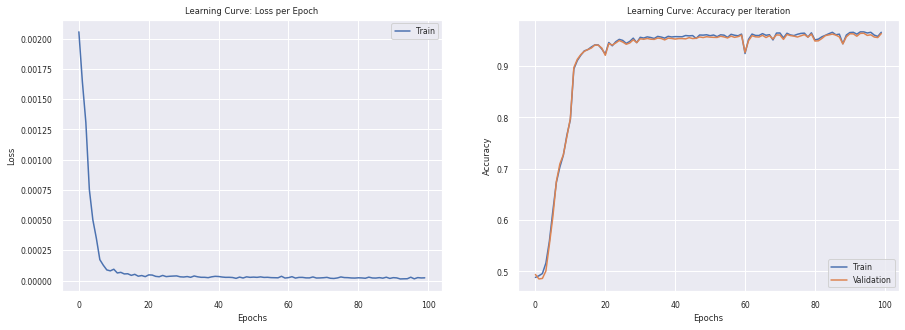

In [ ]:
plot_learning_curve(learning_curve_info)

##Grid Search

**Hyper Parameters Grid Search**

In this section, we will use Grid Search (from Sklearn) to gather information about the various hyper parameters (including architecture parameters). We are saving each run to an excel sheet and will plot and discuss the results in the "result analysis" section. 

We didn't see the need to plot the training curve each time because we realized after a while that the curve should look like the one above - monotonic increase with nice slop and no significant gap between the train and validation datasets. As a result, we decide to investigate the impact of various hyperparameters on the outcome.

We keep the print of the first two combinations to show how it looks, but the rest of the results are in separate files.

During the search, we begin to get a sense of what is to come and begin to fine-tune the grid-search (is not realistice to run 1.5 million combination, not even we used both google colab and azure on differente computers)


In [ ]:
def print_params(params_dict):
    print("Cost Function: ", params_dict['cost'])
    print("Optimizer: ", params_dict['optimizer'])
    print("Learning Rate: ", params_dict['learning_rate'])
    print("Normalization: ", params_dict['normalization'])
    print("Dropout: ", params_dict['dropout'])
    print("Dropout Value: ", params_dict['dropout_value'])
    print("Weight Decay: ", params_dict['weight_decay'])
    print("Batch Size: ", params_dict['batch_size'])
    print("Number of Epochs: ", params_dict['epochs'])
    print("Size of Hidden Layers: ", params_dict['hidden_layers_size'])
    print("Amount of Hidden Layers: ", params_dict['hidden_layers'])
    print("Activation Function: ", params_dict['activation_function'])
    print("Bypass: ", params_dict['bypass'])


def grid_search(train_data, validation_data, test_data, hyperparameters):
    """
    perform a grid search for the best hyper parameters for out model,
    need to get as input the differente dataset and the list for all the hyperparameters.
    then the function will create a list with all possible combinations and for each
    of them, create a model, train it and save the resulte in excel sheet
    """
    combinations = list(itertools.product(*hyperparameters.values()))
    best_val_acc = 0
    best_hyperparameters = None
    file_to_save='/content/gdrive/My Drive/Colab Notebooks/gridSearch_1.csv'
    column_names = ['val_acc','cost','optimizer','lr','normal','dropout','dropout_val',\
                    'wd','batch','epoch','hidden_layers_size','hidden_layers','activation_function','bypass']
    pi = pd.DataFrame(columns=column_names)
    pi.to_csv(file_to_save, index=False)
    # Iterate through all combinations of hyperparameters
    i=0
    for combination in combinations:
        print("*"*20 )
        # Convert the combination tuple to a dictionary
        hypers = dict(zip(hyperparameters.keys(), combination))
        if torch.cuda.is_available():
          model = FirstBasicNN(num_hidden=hypers['hidden_layers_size'], activation=hypers['activation_function'], dropout=hypers['dropout'], 
            dropout_value=hypers['dropout_value'], norm=hypers['normalization'],
            number_of_layers=hypers['hidden_layers'], bypass=hypers['bypass']).cuda()
        else:
          model = FirstBasicNN(num_hidden=hypers['hidden_layers_size'], activation=hypers['activation_function'], dropout=hypers['dropout'], 
            dropout_value=hypers['dropout_value'], norm=hypers['normalization'],
            number_of_layers=hypers['hidden_layers'], bypass=hypers['bypass'])

        #Initlize all the weights
        model.weight_init(mean=0, std=0.02)
        # Train the model with the current combination of hyperparameters
        aranged_hypers = [hypers['cost'], hypers['optimizer'], hypers['learning_rate'], hypers['weight_decay'], hypers['epochs'], hypers['batch_size']]
        if hypers['bypass'] and hypers['hidden_layers'] <= 3:
            continue
        print_params(hypers)     
        #Get only the validation accuracy as our score
        _, _, _, _, val_accs = train_model(model, train_data, validation_data, test_data, hypers=aranged_hypers)
        # Get the maximum validation accuracy from the training process
        val_acc = max(val_accs)
        par = [val_acc,hypers['cost'],hypers['optimizer'],hypers['learning_rate'],\
               hypers['normalization'],hypers['dropout'],hypers['dropout_value'],\
               hypers['weight_decay'],hypers['batch_size'],hypers['epochs'],\
               hypers['hidden_layers_size'],hypers['hidden_layers'],hypers['activation_function'],hypers['bypass']]
        pip = pd.DataFrame(columns=column_names)
        pip.loc[i]=par
        pip.to_csv(file_to_save, mode='a', header=False)
        # Update the best hyperparameters if the current combination results in a higher accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_hyperparameters = combination

    # Print the best hyperparameters and their corresponding validation accuracy
    print("Best hyperparameters:", best_hyperparameters)
    print("Best validation accuracy: %.2f%%" % (best_val_acc * 100))
    return best_hyperparameters


param_grid = {'cost': ['MSE', 'CE', 'BCEWithLogitsLoss'],
              'optimizer': ['SGD', 'RMS', 'ADAM', 'ADAMAX'],
              'learning_rate': [1e-3, 0.01, 0.1, 0.5],
              'normalization': ['LayerNorm', 'None'],
              'dropout': ['Dropout', 'None'],
              'dropout_value': [0.2],
              'weight_decay': [0, 1e-8, 1e-5, 1e-3],
              'epochs': [50, 100, 150, 200],
              'hidden_layers_size': [10, 20, 30, 40, 50],
              'hidden_layers': [2, 3, 4, 5, 6, 7],
              'activation_function': ['ReLU', 'Sigmoid', 'Tanh'],
              'batch_size': [500, 1000, 5000],
               'bypass': [True, False]
              }
            

grid_search(train, valid, test, param_grid)

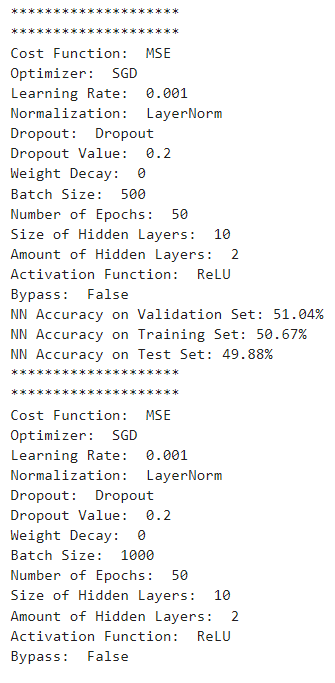

##Best Model

**Best Model**
We will show the proccess of the hyperParameter tunning and analysis in the **"Resulte analysis"** section.

In [28]:
if torch.cuda.is_available():
  bestModel = FirstBasicNN(num_hidden=30,number_of_layers=3,bypass=False,
                         activation='Sigmoid',dropout=0,dropout_value=0,norm='LayerNorm').cuda()
else:
  bestModel = FirstBasicNN(num_hidden=30,number_of_layers=3,bypass=False,
                         activation='Sigmoid',dropout=0,dropout_value=0,norm='LayerNorm')
bestModel.weight_init(mean=0, std=0.02)
learning_curve_info = train_model(bestModel, train,valid ,test,
                            hypers=['BCEWithLogitsLoss','ADAMAX',0.0002,0.001,1000,1000],flag=True)


******************** Epoch   0 ***************
NN Accuracy Train: 49.230 | Validation: 50.368
******************** Epoch   5 ***************
NN Accuracy Train: 50.650 | Validation: 51.163
******************** Epoch  10 ***************
NN Accuracy Train: 50.780 | Validation: 50.984
******************** Epoch  15 ***************
NN Accuracy Train: 50.880 | Validation: 51.084
******************** Epoch  20 ***************
NN Accuracy Train: 50.900 | Validation: 51.183
******************** Epoch  25 ***************
NN Accuracy Train: 51.170 | Validation: 51.342
******************** Epoch  30 ***************
NN Accuracy Train: 51.220 | Validation: 51.362
******************** Epoch  35 ***************
NN Accuracy Train: 55.440 | Validation: 55.538
******************** Epoch  40 ***************
NN Accuracy Train: 92.030 | Validation: 92.503
******************** Epoch  45 ***************
NN Accuracy Train: 95.630 | Validation: 96.500
******************** Epoch  50 ***************
NN Accuracy T

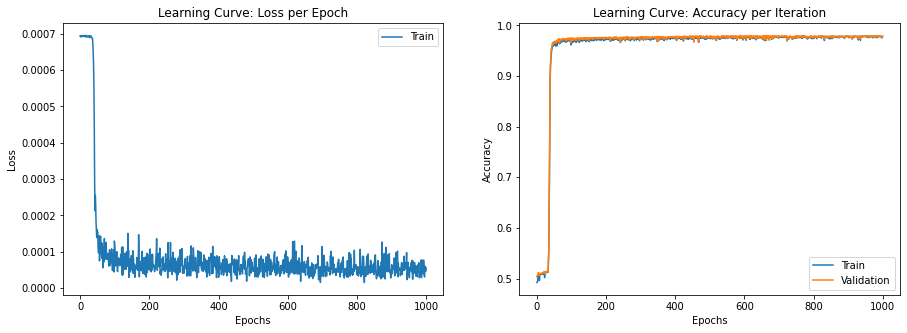

In [37]:
plot_learning_curve(learning_curve_info)

# Benchmark

Our main goal was to do better than the [top-performing model](https://www.kaggle.com/code/acarahmet/league-of-legends) we found on Kaggle. They had tried out many different models and achieved the best results. So we tried to replicate their models and also added new ones like XGBoost and Random Forest. We want to compare our results to theirs and do even better. We know that decision trees are commonly used for this problem, but we're confident we can do better than those standard models.


The performance of the Kaggle model, in summary:

The performance of different models on the test set is as follows:

Logistic Regression: 95.93% accuracy
K-Nearest Neighbors (KNN): 91.5% accuracy
Support Vector Machine (SVM): 96.1% accuracy
Naive Bayes: 93.6% accuracy
Decision Tree: 95.7% accuracy
Random Forest: 97% accuracy
These results demonstrate that the Random Forest model has the highest accuracy on the test set, with 97%. SVM also performs well, achieving an accuracy of 96.1%. Logistic Regression and Decision Tree models perform relatively similarly with accuracies of 95.93% and 95.7%, respectively. KNN and Naive Bayes models have lower accuracies of 91.5% and 93.6%, respectively.


In order to evalute our model, we compared it to different models, to 

observe the results and compare them to our network. 

We choose the following models:


* XGBoost

* Random Forest

* KNN

* SVM

We chose to include the XGBoost model in our analysis because of our familiarity with its capabilities. Moreover, we believed that incorporating this model would pose an interesting challenge and allow us to explore new avenues for improving predictive performance. 

The Following Code is the implementation of each of them


In [ ]:
### SVM 

def estimate_accuracy_svm(model, data, labels, batch_size=5000, max_N=100000):
    """
    Estimate the accuracy of the model on the data. To reduce
    computation time, use at most `max_N` elements of `data` to
    produce the estimate.
    """
    correct = 0
    N = 0
    for i in range(0, len(data), batch_size):
        # get a batch of data
        xt, st = get_batch(data, labels, i, i + batch_size)
        # forward pass prediction
        y = model.predict(xt)
        pred = np.squeeze(y)
        correct += np.sum(pred==st)
        N += len(st)

        if N > max_N:
            break
    return correct / N



def svmModel(train, valid, test):
    x_train, y_train = train
    x_valid, y_valid = valid
    x_test, y_test = test
    y_train = np.argmax(y_train, axis=1)
    y_valid = np.argmax(y_valid, axis=1)
    y_test = np.argmax(y_test, axis=1)
    svm_model = svm.SVC()
    svm_model.fit(x_train, y_train)
    y_pred = svm_model.predict(x_test)
    print("SVM Accuracy on validation set: {:.2f}%".format(estimate_accuracy_svm(svm_model, x_valid, y_valid) * 100))
    print("SVM Accuracy on test set: {:.2f}%".format(estimate_accuracy_svm(svm_model, x_test, y_test) * 100))
    print("SVM Accuracy on train set: {:.2f}%".format(estimate_accuracy_svm(svm_model, x_train, y_train) * 100))


svmModel(train, valid, test)
         

  

SVM Accuracy on validation set: 86.72%
SVM Accuracy on test set: 85.67%
SVM Accuracy on train set: 85.94%


In [ ]:
### KNN
def estimate_accuracy_KNN(model, data, labels, batch_size=5000, max_N=100000):
    """
    Estimate the accuracy of the model on the data. To reduce
    computation time, use at most `max_N` elements of `data` to
    produce the estimate.
    """

    correct = 0
    N = 0
    for i in range(0, len(data), batch_size):
        # get a batch of data
        xt, st = get_batch(data, labels, i, i + batch_size)
        # forward pass prediction
        y = model.predict(xt)
        pred = np.squeeze(y)
        correct += np.sum(pred==st)
        N += len(st)
        if N > max_N:
            break
    return correct / N

def KNN(train,valid,test):
    x_train, y_train = train
    x_valid, y_valid = valid
    x_test, y_test = test
    y_train = np.argmax(y_train, axis=1)
    y_valid = np.argmax(y_valid, axis=1)
    y_test = np.argmax(y_test, axis=1)
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print("KNN Accuracy on validation set: {:.2f}%".format(estimate_accuracy_KNN(model, x_valid, y_valid) * 100))
    print("KNN Accuracy on test set: {:.2f}%".format(estimate_accuracy_KNN(model, x_test, y_test) * 100))
    print("KNN Accuracy on train set: {:.2f}%".format(estimate_accuracy_KNN(model, x_train, y_train) * 100))

KNN(train, valid, test)

KNN Accuracy on validation set: 51.68%
KNN Accuracy on test set: 51.53%
KNN Accuracy on train set: 69.45%


In [38]:
### XGBoost

def compare_xgb_predictions(xgb_model, X, y):
    # Make predictions using the trained model
    #global n, y_test,x_test,x_valid,y_valid
    xgb_predictions = xgb_model.predict(X)

    # Round the predictions to 0 or 1
    xgb_predictions = [round(pred) for pred in xgb_predictions]

    # Compare the predictions with the real labels
    correct = 0
    total = len(X)
    for pred, label in zip(xgb_predictions, y):
        if pred == label:
            correct += 1
    # Calculate the accuracy of the predictions
    accuracy = correct / total
    return accuracy



  
def xgb_classifier(train,valid,test):
    #global n, y_test,x_test,x_valid,y_valid
    x_train, y_train = train
    x_valid, y_valid = valid
    x_test, y_test = test
    y_train = np.argmax(y_train, axis=1)
    y_valid = np.argmax(y_valid, axis=1)
    y_test = np.argmax(y_test, axis=1)
    #  Write your code here
    model = xgb.XGBClassifier()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    temp = model.score(x_test,y_test)
    print("XGB Accuracy on train set: {:.2f}%".format(compare_xgb_predictions(model, x_train, y_train) * 100))
    print("XGB Accuracy on validation set: {:.2f}%".format(compare_xgb_predictions(model, x_valid, y_valid) * 100))
    print("XGB Accuracy on test set: {:.2f}%".format(compare_xgb_predictions(model, x_test, y_test) * 100))
          #"compare_xgb_predictions(model, x_test, y_test))

xgb_classifier(train, valid, test)

XGB Accuracy on train set: 98.09%
XGB Accuracy on validation set: 98.31%
XGB Accuracy on test set: 98.07%


Random Forest

In [ ]:
def random_forest(train_data, validation_data, test_data):
    # Create a random forest classifier
    clf = RandomForestClassifier(n_estimators=50, max_depth=3, random_state=0)

    # Train the classifier
    clf.fit(train_data[0], np.argmax(train_data[1],axis=1))

    # Predict the labels of the test set
    preds = clf.predict(validation_data[0])

    # Compute the accuracy: accuracy
    accuracy = accuracy_score(np.argmax(validation_data[1], axis=1), preds)
    print("Random Forest Accuracy on Validation Set: %.2f%%" % (accuracy * 100))
    print("Random Forest Accuracy on Training Set: %.2f%%" % (accuracy_score(np.argmax(train_data[1], axis=1), clf.predict(train_data[0])) * 100))
    print("Random Forest Accuracy on Test Set: %.2f%%" % (accuracy_score(np.argmax(test_data[1], axis=1), clf.predict(test_data[0])) * 100))

def accuracy_score(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

random_forest(train, valid, test)

Random Forest Accuracy on Validation Set: 96.00%
Random Forest Accuracy on Training Set: 96.31%
Random Forest Accuracy on Test Set: 96.06%


**Summerize of the benchmark result**

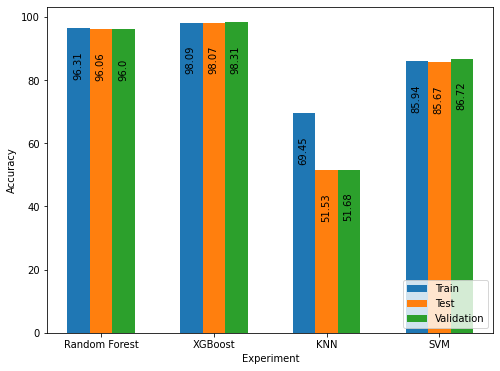

In [40]:
Results = [[96.31,96.00, 96.06], [98.09, 98.31,98.07], [69.45, 51.68, 51.53],[85.94, 86.72, 85.67]]
Models = ["Random Forest", "XGBoost", "KNN", "SVM"]
def plot_accuracies(accuracies, models):
  """
  Plot the train, test, and validation accuracy in one bar plot.
  """
  x = np.arange(len(accuracies))
  train_acc = [acc[0] for acc in accuracies]
  test_acc = [acc[2] for acc in accuracies]
  val_acc = [acc[1] for acc in accuracies]
  fig, ax = plt.subplots()
  width = 0.2
  ax.bar(x - width, train_acc, width, label='Train')
  ax.bar(x, test_acc, width, label='Test')
  ax.bar(x + width, val_acc, width, label='Validation')
  ax.set_xlabel('Experiment')
  ax.set_ylabel('Accuracy')
  ax.set_xticks(x)
  ax.set_xticklabels(models)
  ax.legend(loc='lower right')

  for i, v in enumerate(train_acc):
    ax.text(i - width - 0.05, v - 15.5, str(v), color='black', rotation=90)
  for i, v in enumerate(test_acc):
    ax.text(i - 0.05, v -15.5, str(v), color='black', rotation=90)
  for i, v in enumerate(val_acc):
    ax.text(i + width - 0.05, v -15.5, str(v), color='black', rotation=90)
  fig.set_figheight(6)
  fig.set_figwidth(8)
  plt.show()

plot_accuracies(Results, Models)




#  Result analysis

As observed from the results, the XGBoost model outperformed the other models with an accuracy of 98.07% on the test dataset. We believe that the dataset is more compatible with decision tree models, which could be the reason why the XGBoost model performed exceptionally well.

The high performance of the XGBoost model does not come as a surprise to us, given its capability to handle large datasets and its efficient handling of non-linear relationships between features.


First, we will analyse the *GridSearch* result (and explain how we choose the best hyperParameters).

Then, we will analyse the *Best Model* result.

## Hyperparameter Analysis through GridSearch







We generated a parameter grid and exhaustively tested all possible combinations, saving the results in a CSV file. As we analyzed the outcomes, we identified the parameters that yielded better results, and proceeded to continue running the model with them. Conversely, we discarded parameters that did not enhance or even worsened the model, such as the SGD optimizer or MSE cost function.

After iterating in over 50,000 combinations of hyper paramters, 
we buid a function to filter the result and sort them by accuracy (on the validation set).

Afterwards, we constructed a 3D plotting function that maps three features and uses the validation accuracy to color code the points.

The corresponding code is attached at the end, where you can find the parameters we utilized to generate the subsequent plot.

At the outset, since each sample in our dataset does not possess many features, we decided to examine whether integrating **dropout** would be advantageous or disadvantageous to our model. We conducted multiple runs with and without dropout to evaluate this, and we discovered that adding dropout actually worsened our results. It is worth noting that we did not observe any overfitting in any of our experiments, and in certain cases, the accuracy of the validation and test sets surpassed that of the training set.

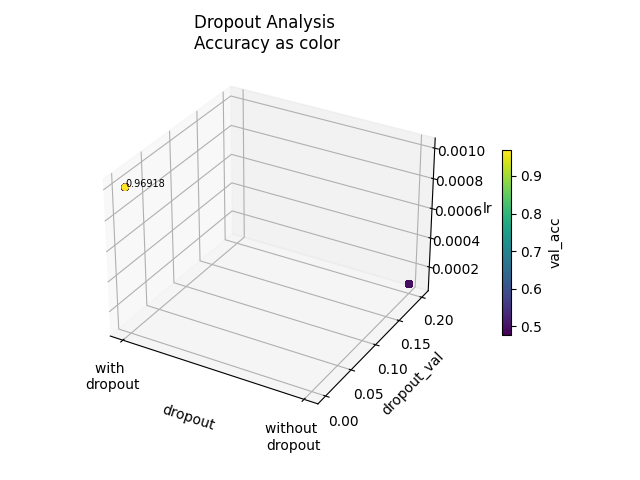

It is apparent that the results obtained by utilizing the SGD optimizer are not as favorable as those generated by the Adam optimizer.

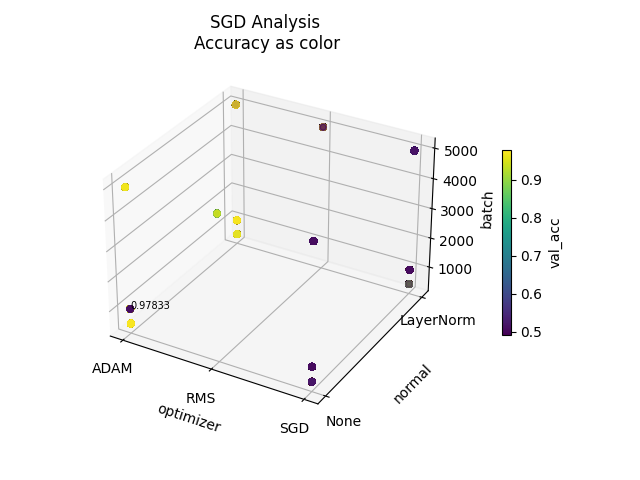

*Cost function and Optimizer* - ADAMAX with BCE

The Adam optimizer generated the most favorable results, while the BCE loss function was found to be the best option. As a classification problem, we expected that the BCE loss function would outperform the others due to its effectiveness in classifying categorical data, regardless of the optimizer used.


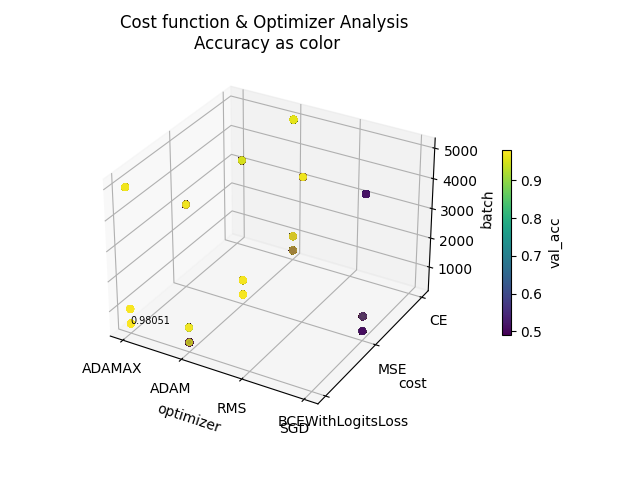

*HyperParameter 1* : [LearningRate, WeigthDecay, Normalization]
The results clearly indicate that the model performed better when Layer Normalization was utilized. Additionally, a higher weight decay value led to superior performance, whereas a lower learning rate was deemed to be the optimal choice.

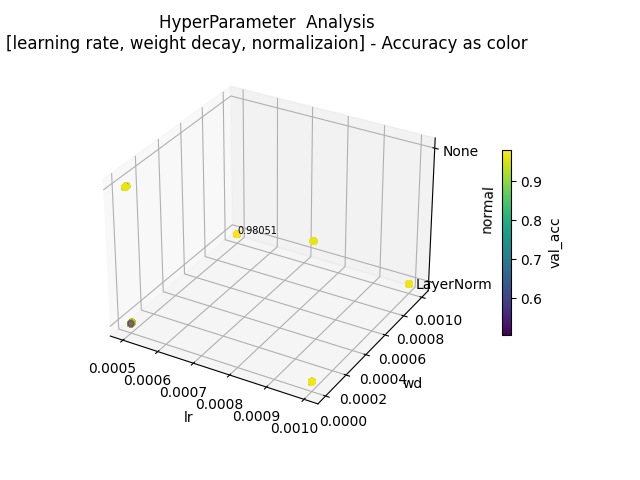

*HyperParameter 2* [ActivationFunction, BatchSize, Epoch]

The observed results can be attributed to the selected hyperparameters. Using the sigmoid activation function was found to be optimal for the model, likely due to the categorical nature of the classification problem. Furthermore, employing a low batch size was advantageous, as it allowed the model to update its parameters more frequently and thus converge faster. Lastly, the model did not require a high number of epochs to attain optimal results, which may be attributable to the aforementioned hyperparameters and the structure of the model itself.

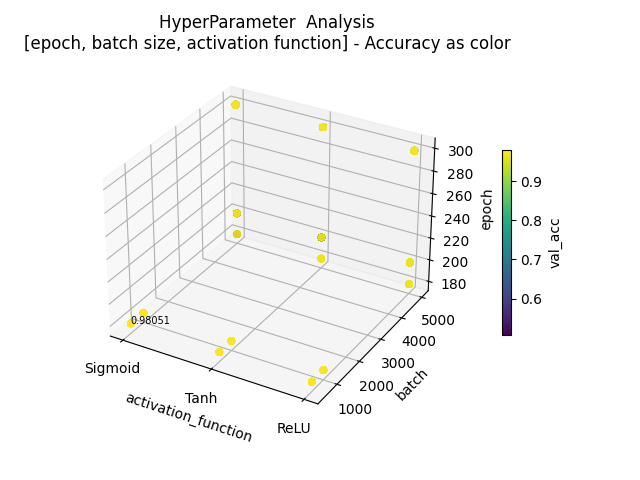

*NetworkArchitecture 2* [size of layer, number of layers, bypass (0-without, 1-with)]

The observed results can be attributed to the selected hyperparameters. It was found that using 30 neurons, equivalent to the size of the input, was beneficial in optimizing the model's performance. Employing three layers was sufficient, and therefore, using a bypass was not required. This indicates that the model architecture was structured optimally for the given task.

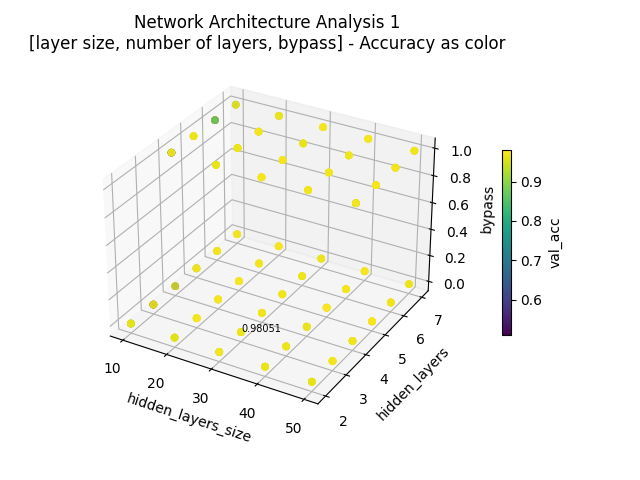

*NetworkArchitecture 2* [ActivationFunction, number of layers, size of layer]

Same as in the graph above.

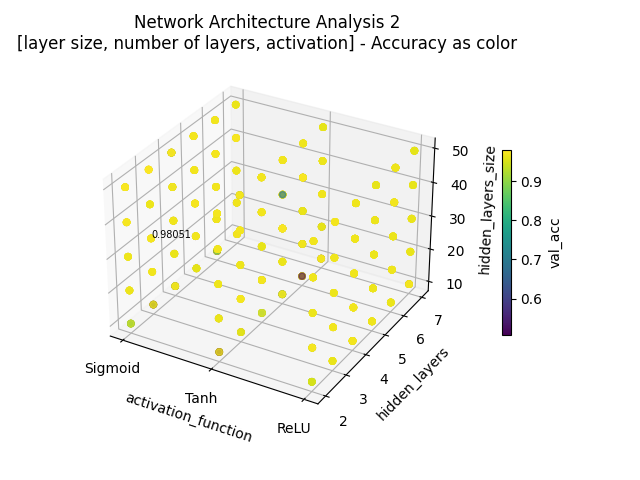

Csv Modification and filtering.

In [ ]:
def filter_csv(csv,filter,amount=0):
    """
    filter the csv file by the filter list,
    sort according to validation accuracy 
    and return the amount of rows
    :param amount: how many rows to return
    """
    df1 = pd.read_csv(csv)
    n = len(filter)
    for i in range(n):
        df1 = df1[df1[filter[i][0]] == filter[i][1]]
    df1 = df1.sort_values(by=[df1.columns[0]], ascending=False)
    if amount != 0:
        df1 = df1.head(amount)
    df1.reset_index(inplace=True)
    return df1

def scatter_3d(df,x,y,z,color,plot_name):
    """
    plot 3d scatter plot of 3 features and color by the validation accuracy.
    Some of the features are categorical and we need to convert them to numeric
    :param color: must be the validation accuracy
    """
    fig = plt.figure()
    df1=df.copy()
    if type(df1[x][0])==str:
        print("x is str")
        unique_categories_x = df1[x].unique()
        numeric_categories_x = [i for i in range(len(unique_categories_x))]
        df1[x] = df1[x].replace(unique_categories_x, numeric_categories_x)
    if type(df1[y][0])==str:
        print("y is str")
        unique_categories_y = df1[y].unique()
        numeric_categories_y = [i for i in range(len(unique_categories_y))]
        df1[y] = df1[y].replace(unique_categories_y, numeric_categories_y)
    if type(df1[z][0])==str:
        print("z is str")
        unique_categories_z = df1[z].unique()
        numeric_categories_z = [i for i in range(len(unique_categories_z))]
        df1[z] = df1[z].replace(unique_categories_z, numeric_categories_z)

    ax = fig.add_subplot(111, projection='3d')
    sc=ax.scatter(df1[x], df1[y], df1[z], c=df1[color], cmap='viridis', marker='o')

    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)
    ax.set_title(plot_name)
    if type(df[x][0])==str:
        if len(numeric_categories_x) > 1:
            ax.set_xticks(numeric_categories_x)
        else:
            ax.set_xticks([1])
        ax.set_xticklabels(unique_categories_x)

    if type(df[y][0])==str:
        if len(unique_categories_y) > 1:
            ax.set_yticks(numeric_categories_y)
        else:
            ax.set_yticks([1])
        ax.set_yticklabels(unique_categories_y)
    if type(df[z][0])==str:
        if len(unique_categories_z) > 1:
            ax.set_zticks(numeric_categories_z)
        else:
            ax.set_zticks([1])
        ax.set_zticklabels(unique_categories_z)

    max_color_index = df1[color].idxmax()
    ax.text(df1[x][max_color_index], df1[y][max_color_index], df1[z][max_color_index], round(df1[color][max_color_index],5), size=7,  color='k')

    plt.colorbar(sc,pad=0.1,shrink=0.5,label='val_acc')
    plt.show()

#drop out analysis - we only try it a few time and we realized that it is not good
# df = filter_csv("combined_tzlil_alon.csv", [["cost", "MSE"], ["optimizer", "SGD"]])
# scatter_3d(df,"dropout","dropout_val","lr","val_acc","Dropout Analysis \nAccuracy as color")

#sgd analysis - we try it only with MSE and after that we realized that it is not good
# df = filter_csv("combined_tzlil_alon.csv", [["cost", "MSE"], ["dropout", "None"]])
# scatter_3d(df,"optimizer","normal","batch","val_acc","SGD Analysis \nAccuracy as color")

#cost and optimizer analysis
# df = filter_csv("combined_tzlil_alon.csv", [["dropout", "None"]])
# scatter_3d(df,"optimizer","cost","batch","val_acc","Cost function & Optimizer Analysis \nAccuracy as color")

#hyperparameter analysis 1
# df = filter_csv("combined_tzlil_alon.csv", [["dropout", "None"],["cost","BCEWithLogitsLoss"],["optimizer","ADAMAX"]])
# scatter_3d(df,"lr","wd","normal","val_acc","HyperParameter  Analysis\n[learning rate, weight decay, normalizaion] - Accuracy as color")

#hyperparameter analysis 2
# df = filter_csv("combined_tzlil_alon.csv", [["dropout", "None"],["cost","BCEWithLogitsLoss"],["optimizer","ADAMAX"],["normal","LayerNorm"]])
# scatter_3d(df,"activation_function","batch","epoch","val_acc","HyperParameter  Analysis\n[epoch, batch size, activation function] - Accuracy as color")

#NetworkArchitecture 1 - only with sigmoid
# df = filter_csv("combined_tzlil_alon.csv", [["dropout", "None"],["normal", "LayerNorm"],["cost","BCEWithLogitsLoss"],["optimizer","ADAMAX"],["activation_function","Sigmoid"]])
# scatter_3d(df,"hidden_layers_size","hidden_layers","bypass","val_acc","Network Architecture Analysis 1\n[layer size, number of layers, bypass] - Accuracy as color")

#NetworkArchitecture 2
# df = filter_csv("combined_tzlil_alon.csv", [["dropout", "None"],["normal", "LayerNorm"],["cost","BCEWithLogitsLoss"],["optimizer","ADAMAX"]])
# scatter_3d(df,"activation_function","hidden_layers","hidden_layers_size","val_acc","Network Architecture Analysis 2\n[layer size, number of layers, activation] - Accuracy as color")


## Best Model - result analysis

Precision score : 0.981
Recall score : 0.981
Sensitivity score : 0.989
Specificity score : 0.974
F1 score : 0.981


0.9785829789119262

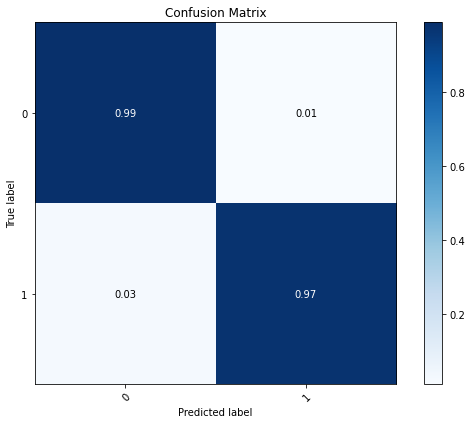

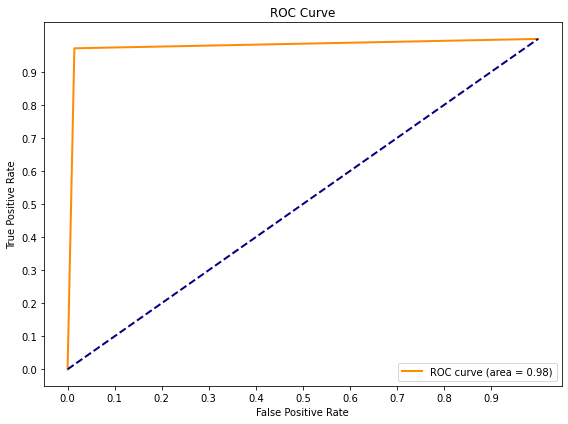

In [42]:
def plot_confusion_matrix(model, valid, target_names, title=None, cmap=plt.cm.Blues):
    model.eval()
    y_true, y_pred = [], []
    valid_data = valid[0]
    valid_labels = valid[1]
    with torch.no_grad():
        for i in range(len(valid_data)):
            output = model(torch.tensor(valid_data[i]).float().cuda())
            y_true.append(valid_labels[i])
            y_pred.append(output.argmax().item())
    #convert y_true from binary one hot to single number
    y_true = np.argmax(y_true, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    accuracy = np.mean(np.array(y_true) == np.array(y_pred))

    if not title:
        title = f"Confusion Matrix (Accuracy: {accuracy:.2f}%)"

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=target_names, yticklabels=target_names,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.grid(False)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return cm



def plot_roc_curve(model, dataloader, target_names, title=None, cmap=plt.cm.Blues):
    model.eval()
    y_true, y_pred = [], []
    valid_data = valid[0]
    valid_labels = valid[1]
    with torch.no_grad():
        for i in range(len(valid_data)):
            output = model(torch.tensor(valid_data[i]).float().cuda())
            y_true.append(valid_labels[i])
            y_pred.append(output.argmax().item())
    y_true = np.argmax(y_true, axis=1)        
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    if not title:
        title = f"ROC Curve (AUC: {roc_auc:.2f}%)"

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set(xticks=np.arange(0, 1, 0.1),
           yticks=np.arange(0, 1, 0.1),
           title=title,
           ylabel='True Positive Rate',
           xlabel='False Positive Rate')

    ax.legend(loc="lower right")
    fig.tight_layout()
    return roc_auc

def print_precision_recall_naive_bayes(model, test, target_names,cm):
    X_test = test[0]
    y_test = test[1]
    y_pred = model(torch.tensor(X_test).float().cuda()).argmax(dim=1)
    y_test = np.argmax(y_test, axis=1) 
    precision = precision_score(y_test, y_pred.detach().cpu().numpy(), average='macro')
    recall = recall_score(y_test, y_pred.detach().cpu().numpy(), average='macro')
    tp = cm[0][0]
    fn = cm[0][1]
    fp = cm[1][0]
    tn = cm[1][1]
    
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = f1_score(y_test, y_pred.detach().cpu().numpy())
    print(f'Precision score : {precision:.3f}')
    print(f'Recall score : {recall:.3f}')
    print(f'Sensitivity score : {sensitivity:.3f}')
    print(f'Specificity score : {specificity:.3f}')
    print(f'F1 score : {f1:.3f}')

cm = plot_confusion_matrix(bestModel, test, ['0', '1'], title='Confusion Matrix')
print_precision_recall_naive_bayes(bestModel, test, ['0', '1'],cm)
plot_roc_curve(bestModel, test, ['0', '1'], title='ROC Curve')

# Conclusion

**explain** provide a brief project summary.


bla bla

# References